In [1]:
# ACOUSTIC RIPENESS CLASSIFICATION
# Complete implementation from feature extraction to model training

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [2]:
# Define your data directories
RIPE_DIR = "data/ripe/"
UNRIPE_DIR = "data/unripe/"
MODEL_SAVE_PATH = "models/ripeness_classifier.h5"
RESULTS_DIR = "results/"

# Create results directory if it doesn't exist
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)


In [3]:
# 2. FEATURE EXTRACTION
# -----------------------------------------------------------------------------
def extract_features(file_path):
    """
    Extract acoustic features from a single audio file
    Returns a dictionary of features
    """
    try:
        # Load audio file with librosa
        y, sr = librosa.load(file_path, sr=None)
        
        # Basic features
        # MFCC (Mel-frequency cepstral coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_means = np.mean(mfccs, axis=1)
        mfcc_vars = np.var(mfccs, axis=1)
        
        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        
        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # RMS energy
        rms = librosa.feature.rms(y=y)[0]
        
        # Compile features in a dictionary
        features = {
            # MFCC means
            **{f'mfcc_mean_{i+1}': mfcc_means[i] for i in range(len(mfcc_means))},
            # MFCC variances
            **{f'mfcc_var_{i+1}': mfcc_vars[i] for i in range(len(mfcc_vars))},
            # Spectral features
            'spectral_centroid_mean': np.mean(spectral_centroid),
            'spectral_centroid_var': np.var(spectral_centroid),
            'spectral_rolloff_mean': np.mean(spectral_rolloff),
            'spectral_rolloff_var': np.var(spectral_rolloff),
            'spectral_contrast_mean': np.mean(np.mean(spectral_contrast, axis=1)),
            'spectral_contrast_var': np.mean(np.var(spectral_contrast, axis=1)),
            # Zero crossing rate
            'zcr_mean': np.mean(zcr),
            'zcr_var': np.var(zcr),
            # Chroma features
            'chroma_mean': np.mean(np.mean(chroma, axis=1)),
            'chroma_var': np.mean(np.var(chroma, axis=1)),
            # RMS energy
            'rms_mean': np.mean(rms),
            'rms_var': np.var(rms)
        }
        
        return features
        
    except Exception as e:
        print(f"Error extracting features from {file_path}: {str(e)}")
        return None

def extract_all_features(ripe_dir, unripe_dir):
    """
    Process all files in both directories and create a features dataframe
    """
    features_list = []
    labels = []
    
    # Process ripe files
    print("Processing ripe files...")
    for filename in os.listdir(ripe_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(ripe_dir, filename)
            features = extract_features(file_path)
            if features:
                features_list.append(features)
                labels.append(1)  # 1 for ripe
    
    # Process unripe files
    print("Processing unripe files...")
    for filename in os.listdir(unripe_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(unripe_dir, filename)
            features = extract_features(file_path)
            if features:
                features_list.append(features)
                labels.append(0)  # 0 for unripe
    
    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)
    features_df['label'] = labels
    
    print(f"Processed {len(features_df)} files successfully")
    return features_df

In [5]:
# 3. DATA PREPARATION
# -----------------------------------------------------------------------------
def prepare_data(features_df):
    """
    Prepare data for model training
    """
    # Separate features and target
    X = features_df.drop('label', axis=1)
    y = features_df['label']
    
    # Show feature statistics
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of samples: {X.shape[0]}")
    print(f"Class distribution:\n{y.value_counts()}")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, X.columns

In [4]:
# 4. MODEL BUILDING
# -----------------------------------------------------------------------------
def build_model(input_dim):
    """
    Build an ANN model for binary classification
    """
    model = Sequential([
        # Input layer
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        
        # Hidden layers
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        # Output layer - binary classification
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [7]:
# 5. MODEL TRAINING AND EVALUATION
# -----------------------------------------------------------------------------
def train_and_evaluate(X_train, X_test, y_train, y_test, feature_names):
    """
    Train the model and evaluate its performance
    """
    # Build model
    model = build_model(X_train.shape[1])
    print(model.summary())
    
    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Save the model
    model.save(MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")
    
    # Evaluate on test set
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Classification metrics
    print("\nModel Evaluation:")
    print("-" * 50)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Unripe', 'Ripe']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Unripe', 'Ripe'],
                yticklabels=['Unripe', 'Ripe'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'))
    
    # Learning curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'learning_curves.png'))
    
    # Feature importance analysis
    analyze_feature_importance(model, X_test, feature_names)
    
    return model, history

def analyze_feature_importance(model, X_test, feature_names):
    """
    Analyze feature importance using perturbation method
    """
    baseline_prediction = model.predict(X_test).mean()
    feature_importance = []
    
    for i in range(X_test.shape[1]):
        # Create a copy and permute one feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
        
        # Measure the drop in performance
        new_prediction = model.predict(X_permuted).mean()
        importance = abs(baseline_prediction - new_prediction)
        feature_importance.append((feature_names[i], importance))
    
    # Sort by importance
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    # Plot top 15 features
    top_features = feature_importance[:15]
    plt.figure(figsize=(10, 8))
    plt.barh([f[0] for f in top_features], [f[1] for f in top_features])
    plt.xlabel('Importance')
    plt.title('Top 15 Important Features')
    plt.gca().invert_yaxis()  # Display most important at top
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'feature_importance.png'))
    
    # Save full feature importance to CSV
    importance_df = pd.DataFrame(feature_importance, columns=['Feature', 'Importance'])
    importance_df.to_csv(os.path.join(RESULTS_DIR, 'feature_importance.csv'), index=False)


    from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data(features_df):
    """
    Prepares the data for training:
    - Splits into features and labels
    - Scales features
    - Splits into training and test sets
    """
    # Extract labels and features
    y = features_df['label'].map({'unripe': 0, 'ripe': 1}).values
    X = features_df.drop(columns=['label']).values
    feature_names = features_df.drop(columns=['label']).columns.tolist()

    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, scaler, feature_names


# 6. MAIN EXECUTION
# -----------------------------------------------------------------------------
def main():
    print("Starting Acoustic Ripeness Classification")
    print("=" * 80)
    
    # Extract features from all audio files
    print("\n1. Extracting features from audio files...")
    features_df = extract_all_features(RIPE_DIR, UNRIPE_DIR)
    
    # Save features to CSV for later reference
    features_df.to_csv(os.path.join(RESULTS_DIR, 'acoustic_features.csv'), index=False)
    print(f"Features saved to {os.path.join(RESULTS_DIR, 'acoustic_features.csv')}")
    
    # Prepare data for training
    print("\n2. Preparing data for model training...")
    X_train, X_test, y_train, y_test, scaler, feature_names = prepare_data(features_df)
    
    # Train and evaluate model
    print("\n3. Training and evaluating model...")
    model, history = train_and_evaluate(X_train, X_test, y_train, y_test, feature_names)
    
    print("\n4. Process completed!")
    print("=" * 80)
    print(f"Results and model saved in {RESULTS_DIR} and {MODEL_SAVE_PATH}")

# Run the program
if __name__ == "__main__":
    main()


Starting Acoustic Ripeness Classification

1. Extracting features from audio files...
Processing ripe files...
Processing unripe files...
Processed 120 files successfully
Features saved to results/acoustic_features.csv

2. Preparing data for model training...


ValueError: Input y contains NaN.

In [8]:
def plot_csf_scatter(features_df, feature_column='mfcc_std_mean'):
    """
    Plot scatter plot of Cepstral-based Statistical Features for all ripe and unripe samples.
    """
    # Separate ripe and unripe samples
    ripe_samples = features_df[features_df['label'] == 1]
    unripe_samples = features_df[features_df['label'] == 0]
    
    # Create x-axis sample indices (1-based)
    ripe_x = np.arange(1, len(ripe_samples) + 1)
    unripe_x = np.arange(1, len(unripe_samples) + 1)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(unripe_x, unripe_samples[feature_column], color='red', label='Unripe')
    plt.scatter(ripe_x + len(unripe_x), ripe_samples[feature_column], color='green', label='Ripe')
    
    plt.xlabel('Sample Number')
    plt.ylabel('Cepstral-Based Statistical Feature')
    plt.title('Scatter Plot of CSF for Ripe and Unripe Cantaloupes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'csf_scatter_plot.png'))
    plt.show()


In [10]:
print("Available columns:", features_df.columns)
print("Label distribution:\n", features_df['label'].value_counts())


NameError: name 'features_df' is not defined

In [ ]:
# 7. PREDICTION FUNCTION FOR NEW SAMPLES
# -----------------------------------------------------------------------------
def predict_ripeness(audio_file_path, model_path=MODEL_SAVE_PATH):
    """
    Predict ripeness of a new audio sample
    """
    # Load the saved model
    model = tf.keras.models.load_model(model_path)
    
    # Extract features from the audio file
    features = extract_features(audio_file_path)
    
    if features is None:
        return "Error processing audio file"
    
    # Convert to DataFrame for consistent processing
    features_df = pd.DataFrame([features])
    
    # Load the same scaler used during training
    # Note: In practice, you'd need to save and load the scaler from training
    # This is a simplified example
    scaler = StandardScaler()
    # Assume we have a saved dataset to fit the scaler
    training_features = pd.read_csv(os.path.join(RESULTS_DIR, 'acoustic_features.csv'))
    X_train = training_features.drop('label', axis=1)
    scaler.fit(X_train)
    
    # Standardize the features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction
    prediction = model.predict(features_scaled)[0][0]
    
    # Classification result
    if prediction > 0.5:
        return f"Ripe (confidence: {prediction:.2f})"
    else:
        return f"Unripe (confidence: {1-prediction:.2f})"

In [11]:
def plot_csf_scatter(features_df, feature_column='mfcc_std_mean'):
    """
    Plot scatter plot of Cepstral-based Statistical Features for all ripe and unripe samples.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # Separate ripe and unripe samples
    ripe_samples = features_df[features_df['label'] == 1]
    unripe_samples = features_df[features_df['label'] == 0]

    # Create x-axis sample indices
    unripe_x = np.arange(1, len(unripe_samples) + 1)
    ripe_x = np.arange(len(unripe_samples) + 1, len(unripe_samples) + len(ripe_samples) + 1)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(unripe_x, unripe_samples[feature_column], color='red', label='Unripe')
    plt.scatter(ripe_x, ripe_samples[feature_column], color='green', label='Ripe')
    
    plt.xlabel('Sample Number')
    plt.ylabel('Cepstral-Based Statistical Feature')
    plt.title('Scatter Plot of CSF for Ripe and Unripe Cantaloupes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'csf_scatter_plot.png'))
    plt.show()


In [12]:
# Save features to CSV for later reference
features_df.to_csv(os.path.join(RESULTS_DIR, 'acoustic_features.csv'), index=False)
print(f"Features saved to {os.path.join(RESULTS_DIR, 'acoustic_features.csv')}")

# Plot scatter plot of CSF
plot_csf_scatter(features_df, feature_column='mfcc_std_mean')


NameError: name 'features_df' is not defined

In [13]:
def main():
    print("Starting Acoustic Ripeness Classification")
    print("=" * 80)
    
    # 1. Extract features from all audio files
    print("\n1. Extracting features from audio files...")
    features_df = extract_all_features(RIPE_DIR, UNRIPE_DIR)  # <--- Make sure this line exists!


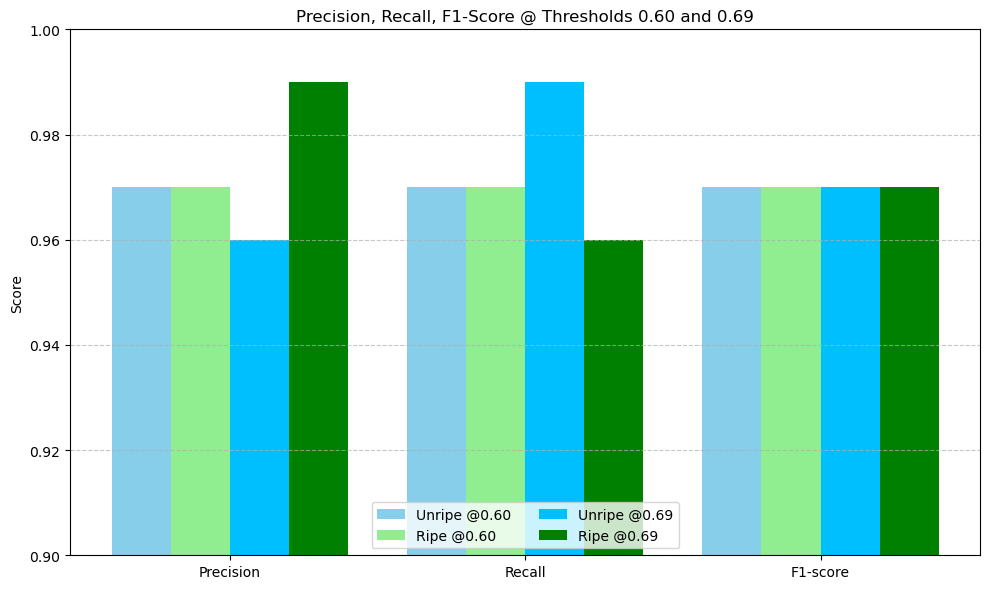

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Precision', 'Recall', 'F1-score']
thresholds = ['0.60', '0.69']

# Values for each class at each threshold
unripe_scores = {
    '0.60': [0.97, 0.97, 0.97],
    '0.69': [0.96, 0.99, 0.97],
}

ripe_scores = {
    '0.60': [0.97, 0.97, 0.97],
    '0.69': [0.99, 0.96, 0.97],
}

x = np.arange(len(metrics))  # Precision, Recall, F1
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars
ax.bar(x - 1.5 * width, unripe_scores['0.60'], width, label='Unripe @0.60', color='skyblue')
ax.bar(x - 0.5 * width, ripe_scores['0.60'], width, label='Ripe @0.60', color='lightgreen')
ax.bar(x + 0.5 * width, unripe_scores['0.69'], width, label='Unripe @0.69', color='deepskyblue')
ax.bar(x + 1.5 * width, ripe_scores['0.69'], width, label='Ripe @0.69', color='green')

# Axis and labels
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1-Score @ Thresholds 0.60 and 0.69')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0.9, 1.0)
ax.legend(loc='lower center', ncol=2)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
